In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import matplotlib.finance as matfin
import matplotlib.ticker as ticker

%matplotlib inline

In [2]:
# DB에 연결
con = sqlite3.connect('/home/dongsu/Downloads/studydata2.sqlite')

In [3]:
# DB 데이터로부터 DataFrame 만들기
# index 는 Timestamp로 변경
df = pd.read_sql(sql="SELECT * FROM t8413", con=con, index_col='date')
df.index = pd.to_datetime(df.index)

In [5]:
# 이동평균선 구하기(5일/20일/60일/120일)
ma5 = df['close'].rolling(window=5).mean()
ma20 = df['close'].rolling(window=20).mean()
ma60 = df['close'].rolling(window=60).mean()
ma120 = df['close'].rolling(window=120).mean()

# DataFrame에 추가
df.insert(len(df.columns), "MA5", ma5)
df.insert(len(df.columns), "MA20", ma20)
df.insert(len(df.columns), "MA60", ma60)
df.insert(len(df.columns), "MA120", ma120)

In [23]:
# 최근 100건만 
df_rec = df[-100:]

In [24]:
# x축 ticker 원할때에만 표시(달이 넘어갈 때)
day_list = []
dates = []
month = df_rec.index[0].date().month - 1

for i, day in enumerate(df_rec.index):
    if month != day.date().month:
        day_list.append(i)
        dates.append(day.strftime('%Y-%m-%d'))
        month = day.date().month
        
print (day_list)
print (dates)

[0, 21, 38, 59, 81]
['2018-08-02', '2018-09-03', '2018-10-01', '2018-11-01', '2018-12-03']


In [25]:
# 거래량의 bar chart color 를 위한 series
is_pos = df_rec['open']-df_rec['close'] < 0
is_pos.replace({True:'r',False:'b'}, inplace=True) 

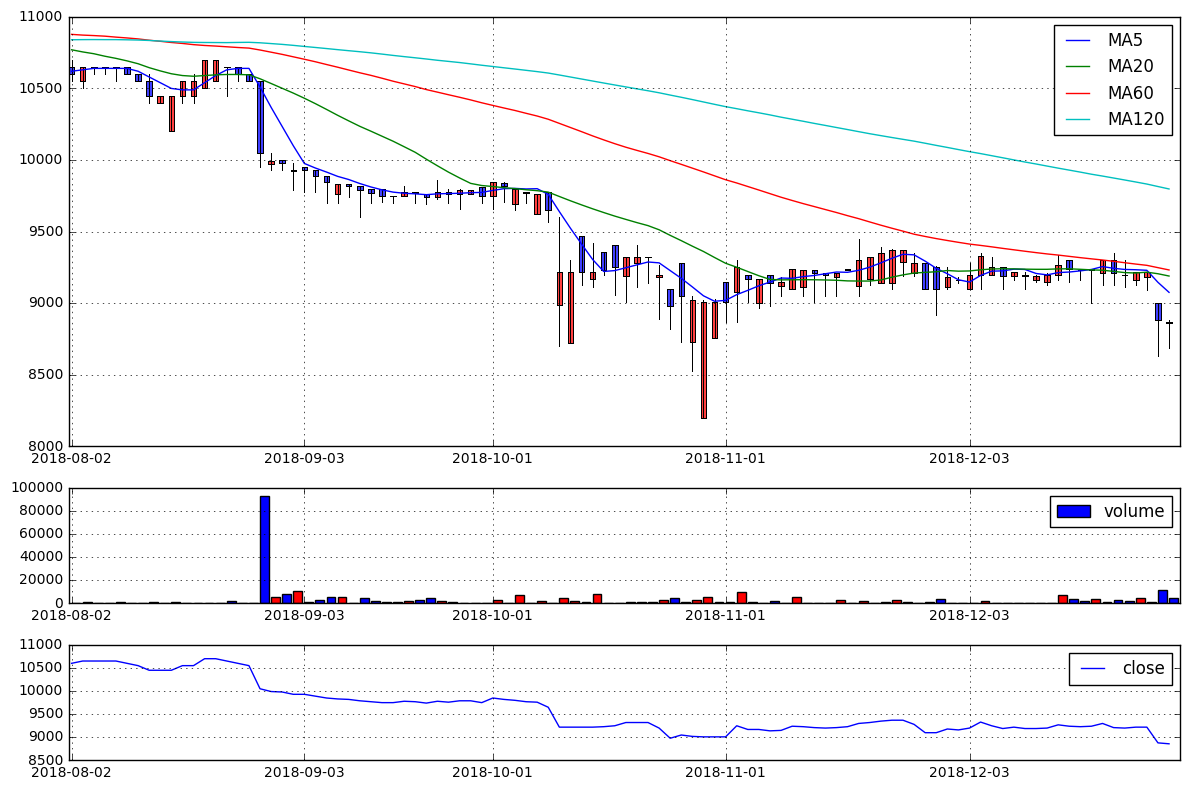

In [26]:
# 양봉 : 시가 < 종가 (빨간색)
# 음봉 : 시가 > 종가 (파란색)
# 종가 > 저가 : 장중에 주가가 떨어졌다가 장 종료 시점에 주가 올라감
# 종가 < 고가 : 장중에 주가가 올랐다가 장 종료 시점에 주가 떨어짐

fig = plt.figure(figsize=(12,8)) # 주식 그래프에서는 보통 높이 < 너비

top_axes = plt.subplot2grid((5,5), (0,0), rowspan=3, colspan=5) # 5X5 grid, (0,0)에 위치, 행 방향 3-grid, 열 방향 5-grid
top_axes.xaxis.set_major_locator(ticker.FixedLocator(day_list))
top_axes.xaxis.set_major_formatter(ticker.FixedFormatter(dates))
# 원하는 x축만 보여주고 모든 subplot에서 x축 공유(sharex)
matfin.candlestick2_ohlc(top_axes, df_rec['open'], df_rec['high'], df_rec['low'], df_rec['close'], width=0.5, colorup='r', colordown='b')
top_axes.plot(range(len(df_rec.index)), df_rec['MA5'], label='MA5')
top_axes.plot(range(len(df_rec.index)), df_rec['MA20'], label='MA20')
top_axes.plot(range(len(df_rec.index)), df_rec['MA60'], label='MA60')
top_axes.plot(range(len(df_rec.index)), df_rec['MA120'], label='MA120')
top_axes.legend(loc=0)
top_axes.grid()

middle_axes = plt.subplot2grid((5,5), (3,0), rowspan=1, colspan=5, sharex=top_axes) # 5X5 grid, (3,0)에 위치, 행 방향 1-grid, 열 방향 5-grid
#middle_axes.get_yaxis().get_major_formatter().set_scientific(False) # 지수 형태(e)로 표현X
middle_axes.bar(range(len(df_rec.index)), df_rec['volume'], label='volume', color=is_pos) # 거래량
middle_axes.legend(loc=0)
middle_axes.grid()

bottom_axes = plt.subplot2grid((5,5), (4,0), rowspan=1, colspan=5, sharex=top_axes) # 5X5 grid, (4,0)에 위치, 행 방향 1-grid, 열 방향 5-grid
bottom_axes.plot(range(len(df_rec.index)), df_rec['close'], label='close')
bottom_axes.legend(loc=0)
bottom_axes.grid()

plt.tight_layout() # subplot 들이 figure 객체 영역 내에서 자동으로 최대 크기로 출력
plt.show()